In [ ]:
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

# Data Preprocessing

In [ ]:
df = pd.read_csv('movies_metadata.csv')

In [ ]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan
df['id'] = df['id'].apply(convert_int)

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
df = df.drop(['imdb_id'], axis=1)
df.drop(['original_title'], axis=1,inplace=True)
df['revenue'] = df['revenue'].replace(0, np.nan)
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df['return'] = df['revenue'] / df['budget']
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year
df.drop(['adult'],axis=1,inplace=True)
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].replace(0, np.nan)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['month'] = df['release_date'].apply(get_month)
df['day'] = df['release_date'].dt.weekday
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x: len(x) if isinstance(x, list) else np.nan)
df['runtime'] = df['runtime'].astype(float)
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
rgf = df[df['return'].notnull()]
rgf.shape

(5381, 25)

In [ ]:
s = rgf.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [ ]:
gen_rgf = rgf.drop('genres', axis=1).join(s)

In [ ]:
genres_train = gen_rgf['genre'].drop_duplicates()

In [ ]:
rgf.describe()

,budget,id,popularity,revenue,runtime,spoken_languages,vote_average,vote_count,return,year,day
count,5.381000e+03,5381.000000,5381.000000,5.381000e+03,5380.000000,5381.000000,5374.000000,5381.000000,5.381000e+03,5381.000000,5381.000000
mean,3.109480e+07,60664.565508,9.774289,9.031812e+07,109.827695,1.481881,6.281020,732.309422,5.565899e+03,1999.757666,3.174131
std,4.016263e+07,95613.916930,13.818399,1.661423e+08,22.041188,0.927831,0.900524,1251.520813,2.168566e+05,15.919325,1.323075
min,1.000000e+00,5.000000,0.000001,1.000000e+00,0.000000,0.000000,1.000000,0.000000,5.217391e-07,1915.000000,0.000000
25%,5.037000e+06,8818.000000,5.443097,7.011317e+06,95.000000,1.000000,5.700000,77.000000,7.870443e-01,1994.000000,2.000000
50%,1.700000e+07,14396.000000,8.388773,2.991874e+07,106.000000,1.000000,6.300000,276.000000,2.056683e+00,2004.000000,4.000000
75%,4.000000e+07,59981.000000,11.720358,9.996575e+07,120.000000,2.000000,6.900000,798.000000,4.244444e+00,2011.000000,4.000000
max,3.800000e+08,443319.000000,547.488298,2.787965e+09,338.000000,9.000000,9.100000,14075.000000,1.239638e+07,2017.000000,6.000000


In [ ]:
rgf.loc[rgf[rgf['belongs_to_collection'].isnull()].index,
        'belongs_to_collection'] = np.nan
rgf['belongs_to_collection'] = np.where(rgf['belongs_to_collection'].isnull(), 0, 1)
rgf['belongs_to_collection']

0        1
1        1
3        1
5        1
8        1
        ..
45250    1
45399    1
45409    1
45412    1
45422    1
Name: belongs_to_collection, Length: 5381, dtype: int64

In [ ]:
rgf['belongs_to_collection'].value_counts()

1    5381
Name: belongs_to_collection, dtype: int64

In [ ]:
for genre in genres_train:
  rgf['is_' + str(genre)] = rgf['genres'].apply(lambda x: 1 if genre in x else 0)

rgf['genres_count'] = rgf['genres'].apply(lambda x: len(x))
rgf['is_english'] = rgf['original_language'].apply(lambda x: 1 if x=='en' else 0)
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'month', 'day',
       'is_Friday', 'is_Holiday', 'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english'],
      dtype='object')

need to process data further

In [ ]:
rgf['is_Friday'] = rgf['day'].apply(lambda x: 1 if x==5 else 0)
rgf['is_Holiday'] = rgf['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Dec'] else 0)
rgf['runtime'] = rgf['runtime'].fillna(df['runtime'].mean())
rgf['vote_average'] = rgf['vote_average'].fillna(rgf['vote_average'].mean())
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'month', 'day',
       'is_Friday', 'is_Holiday', 'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english'],
      dtype='object')

In [ ]:
featureList = [
    'budget',
    'popularity',
    'runtime',
    'vote_average',
    'vote_count',
    'cast_size',
    'crew_size',
    'belongs_to_collection',
    'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Horror',  'is_Western',
       'is_Friday', 'is_Holiday', 'revenue'
]


Start Classification

In [ ]:
X, y = rgf.drop('revenue', axis=1), rgf['revenue']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [ ]:
reg = GradientBoostingRegressor()

In [ ]:
cls = df[df['return'].notnull()]
cls.shape

(5381, 25)

In [ ]:
cls['success'] = cls['return'].apply(lambda x: 1 if x >=1.2 else 0)
cls['belongs_to_collection'] = rgf['belongs_to_collection']

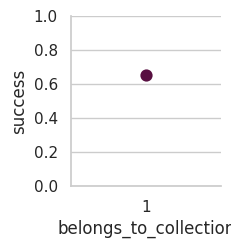

In [ ]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=cls, x_vars=['belongs_to_collection'], y_vars='success')
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

In [ ]:
s = cls.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_cls = cls.drop('genres', axis=1).join(s)

In [ ]:
ctab = pd.crosstab(
    [
        gen_cls['genre']
    ],
    gen_cls['success'],
    dropna=False
).apply(lambda x: x/x.sum(), axis=1)

In [ ]:
for genre in genres_train:
    cls['is_' + str(genre)] = cls['genres'].apply(lambda x: 1 if genre in x else 0)
cls['genres'] = cls['genres'].apply(lambda x: len(x))

In [ ]:
cls['is_english'] = rgf['is_english']
cls['is_Friday'] = rgf['is_Friday']
cls[['runtime', 'vote_average', 'is_Holiday']] = rgf[['runtime', 'vote_average', 'is_Holiday']]

In [ ]:
featureList = featureList = [
    'budget',
    'popularity',
    'runtime',
    'vote_average',
    'vote_count',
    'cast_size',
    'crew_size',
    'belongs_to_collection',
    'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english', 'is_Friday', 'is_Holiday', 'success'
]

In [ ]:
X, y = cls[featureList].drop('success', axis=1), cls['success']

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

In [ ]:
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)

Result

In [ ]:
plt.figure(figsize=(10,12))
sns.barplot(x=clf.feature_importances_, y=X.columns)

In [ ]:
featureImp = pd.DataFrame(
    {
        'col': X.columns,
        'imp': reg.feature_importances_
    }
)
featureImp.sort_values('imp', ascending=False)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(clf2.predict, test_X)
shap_values= explainer(test_X)
shap.plots.bar(shap_values)

# Suggestion Based Recommender

In [ ]:
df = df[df['vote_count'] >= 50]

In [ ]:
movies_md = df[['id', 'original_title', 'overview', 'genres']]
movies_md['title'] = movies_md['original_title'].copy()
movies_md.reset_index(inplace=True, drop=True)
movies_md.head()

In [ ]:
movies_md = movies_md[movies_md['id'].str.isnumeric()]
movies_md['id'] = movies_md['id'].astype(int)
df = pd.merge(movies_md,
         keywords_df,
         on = 'id',
         how = 'left')
credits_df = pd.read_csv('./credits.csv')

In [ ]:
df = pd.merge(df,
              credits_df,
              on = 'id',
              how='left')
df.reset_index(inplace=True, drop=True)

In [ ]:
# Fetchin the genre list from the column
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in eval(x)])

# Replaces spaces in between genre(ex - sci fi to scifi) and make it a string
df['genres'] = df['genres'].apply(lambda x: ' '.join([i.replace(" ","") for i in x]))


In [ ]:
# Filling the numm values as []
df['keywords'].fillna('[]', inplace=True)
# Let's clean the keywords dataframe to extract the keywords
# Fetchin the keyword list from the column
df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in eval(x)])

# Remove the expty spaces and join all the keyword wwwith spaces
df['keywords'] = df['keywords'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))

In [ ]:
# Filling the numm values as []
df['cast'].fillna('[]', inplace=True)
# Let's clean the cast dataframe to extract the name of aactors from cast column
# Fetchin the cast list from the column
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in eval(x)])

# Remove the expty spaces and join all the cast with spaces
df['cast'] = df['cast'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))

In [ ]:
df['tags'] = df['overview'] + ' ' + df['genres'] + ' ' + df['original_title'] + ' ' + df['keywords'] + ' ' + df['cast']
df.drop(columns=['genres','overview', 'original_title', 'cast'], inplace=True)
df.drop(columns=['crew'], inplace=True)
df.drop(df[df['tags'].isnull()].index, inplace=True)
df.drop_duplicates(inplace=True)

Convert the contents to vectors

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize a tfidf object
tfidf = TfidfVectorizer(max_features=5000)

# Transform the data
vectorized_data = tfidf.fit_transform(df['tags'].values)

vectorized_data

Dimension Reduction

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Initialize a PCA object
svd = TruncatedSVD(n_components=3000)

# Fit transform the data
reduced_data = svd.fit_transform(vectorized_data)

# Print the shape
reduced_data.shape
svd.explained_variance_ratio_.cumsum()

Similarity Metric

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(reduced_data)

Make Recommendations for a given movie

In [ ]:
def recommendations(movie_title):
  id_of_movie = df[df['title'] == movie_title].index[0]
  distances = similarity[id_of_movie]
  movie_list = sorted(
      list(
          enumerate(distances)
      ),
      reverse=True,
      key = lambda x: x[1]
  )[1:10]

  for i in movie_list:
    print(df.iloc[i[0]].title)

In [ ]:
recommendations('The Matrix')

Visualize using TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Initialize TSNE object
tsne = TSNE(n_components=2, init='random')

tsne_data = tsne.fit_transform(vectorized_data)

tsne_data = pd.DataFrame(tsne_data,
                         columns=['x', 'y'])

tsne_data['title'] = df['title'].copy()

In [ ]:
data = go.Scatter(
    x=tsne_data['x'],
    y=tsne_data['y'],
    text=tsne_data['title'],
    mode='markers+text'
)

fig = go.Figure(data=data)
fig.show()